
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<!-- <font color=0F5298 size=7> -->
<font color=0F5298 size=6>
    NLP Sentiment Analysis project <br> <br>
<!-- <font color=2565AE size=5> -->
<font size=5>
    Computer Engineering Department <br>
    Spring 2023 <br> <br>

    
____

### Full Name : Pardis Zahraei
### Student Number : 99109777
### Colab Link: https://colab.research.google.com/drive/1YhBI3H6eZOvBM7zeYmsiSfdKhwri_v1l?usp=sharing
___

# step 0 : unzip data + download + import packages + splitting the data + EDA

In [1]:
!unzip sharif-ml-1401-pr.zip

Archive:  sharif-ml-1401-pr.zip
  inflating: pr-test-data-sample_submission.csv.csv  
  inflating: pr-test-data.csv        
  inflating: pr-training-data.csv.csv  


packages:

In [ ]:
# run with GPU
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import  GlobalMaxPool1D, SpatialDropout1D
from keras.layers import Bidirectional
from keras.models import Model
from keras import optimizers
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive
from sklearn.model_selection import train_test_split
import nltk
import unicodedata, re, string
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from gensim.models import KeyedVectors
from keras.optimizers import Adam

getting fastText dataset. I have already downloaded it and saved it in my google drive but I put the code in comment for downloading as well

In [ ]:
"""
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip crawl-300d-2M.vec.zip
"""

drive.mount('/content/drive')
file_path = './crawl-300d-2M.vec'
drive_dir_path = '/content/drive/MyDrive/Colab Notebooks/'
#!cp "{file_path}" "{drive_dir_path}"
file_path = drive_dir_path + 'crawl-300d-2M.vec'
"""
def load_embeddings(file_path,word_index):
    set_m = {}
    with open(file_path, 'r') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            set_m[word] = coefs
    num_words = min(20000, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, 300))
    for i in range(num_words):
        word = word_index.get(i)
        if word is not None:
            embedding_vector = set_m.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip
embeddings_index = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')
from google.colab import drive
drive.mount('/content/drive')
kv_path = '/content/drive/MyDrive/wiki-news-300d-1M.kv'
embeddings_index.save(kv_path)
"""
drive.mount('/content/drive')
kv_path = '/content/drive/MyDrive/wiki-news-300d-1M.kv'
embeddings_index = KeyedVectors.load(kv_path)


In [ ]:
df = pd.read_csv("pr-training-data.csv.csv")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
final = pd.read_csv("pr-test-data.csv")
final.head()

,PhraseId,SentenceId,Phrase,ID
0,15061,8545,As exciting as all this exoticism might sound ...,1
1,15062,8545,As exciting as all this exoticism might sound ...,2
2,15063,8545,exciting as all this exoticism might sound to ...,3
3,15064,8545,exciting as all this exoticism might sound to ...,4
4,15065,8545,as all this exoticism might sound to the typic...,5


<Axes: title={'center': 'Number of sentiment class'}, xlabel='Sentiment', ylabel='count'>

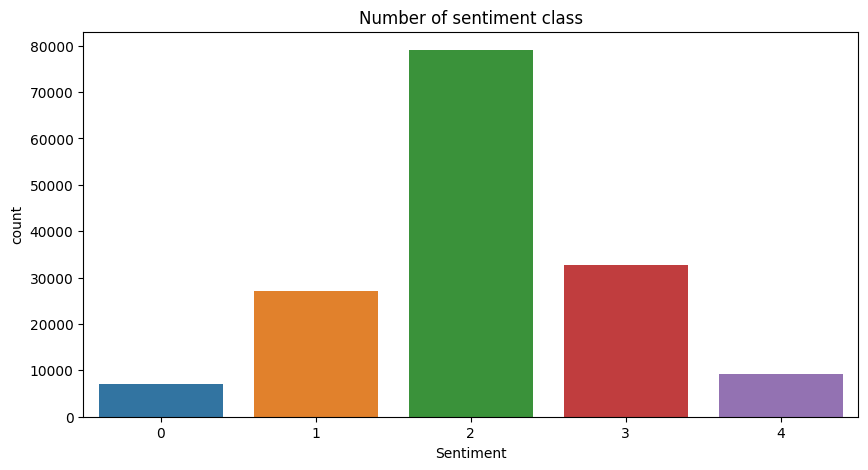

In [ ]:
## Show the number of class distributed
plt.figure(figsize=(10,5))
ax=plt.axes()
ax.set_title('Number of sentiment class')
sns.countplot(x=df.Sentiment,data=df)

In [ ]:
corr = df[['SentenceId', 'Sentiment']].corr()
print(corr)

            SentenceId  Sentiment
SentenceId  1.000000   -0.009286 
Sentiment  -0.009286    1.000000 


because of weak correlation we can ignore it

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

splitting the data into three training validation and test sets. (its not neccessary to split into test because we are using NN but just following protocols in next models I wont do that)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Phrase'], df['Sentiment'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
X_train

82426     ca n't disguise the fact that it 's inauthentic at its core and that its story just is n't worth telling .                     
28336     does this so well                                                                                                              
109621    gross out                                                                                                                      
69155     a Pandora 's Box                                                                                                               
35997     Newcastle , the first half of Gangster No. 1 drips with style and                                                              
                                        ...                                                                                              
42055     pretends                                                                                                                       
88538     like whether compromise 

# step 2: preprocess the data (methods 1 and 2 )

## method 1

first I defined a preprocess function which does the basic EDA tasks on data (its kinda redundant knowing dataset isnt so valid as given in the report)

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove Numbers
    text = ''.join([char for char in text if not char.isdigit()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
X_train

82426     ca nt disguise fact inauthentic core story nt worth telling                             
28336     well                                                                                    
109621    gross                                                                                   
69155     pandora box                                                                             
35997     newcastle first half gangster drip style                                                
                            ...                                                                   
42055     pretend                                                                                 
88538     like whether compromise death self orgasm lrb wo nt rrb exceedingly memorable one people
83673     thoughtlessly assembled                                                                 
7633      position                                                                                
44536     

we can see the diffrence in the above that cleaning the dataset makes it better in my logic but not in this dataset

## method 2 (fastText)

I didi two approaches for fastText first is using wiki-news-300d-1M.kv second is crawl-300d-2M.vec which are both from fastText dataset anyway and can be used for preprocessing and embedding

In [ ]:
def get_embedding(text):
    words = text.split()
    embeddings = [embeddings_index.get_vector(word) for word in words if word in embeddings_index]
    if len(embeddings) == 0:
        return np.zeros(300)
    else:
        return np.mean(embeddings, axis=0)

X_train_fasttext = np.array([get_embedding(text) for text in X_train])
X_val_fasttext = np.array([get_embedding(text) for text in X_val])
X_test_fasttext = np.array([get_embedding(text) for text in X_test])

In [ ]:
X_train_fasttext

array([[ 5.47599904e-02, -5.20700030e-02, -6.90600052e-02, ...,
         1.00670002e-01, -5.75899966e-02, -6.24199994e-02],
       [-1.28900006e-01,  1.15000000e-02,  3.29999998e-03, ...,
         1.81099996e-01,  3.97999994e-02, -5.29999994e-02],
       [ 8.83999988e-02, -7.10999966e-02, -3.29000019e-02, ...,
         1.57399997e-01,  1.20099999e-01,  8.03000033e-02],
       ...,
       [ 1.02749996e-01, -8.68000016e-02,  1.66499987e-02, ...,
         1.27350003e-01, -3.84000018e-02,  9.57499966e-02],
       [ 6.31999969e-02,  4.94999997e-02, -7.27000013e-02, ...,
         7.30000017e-03, -3.09999995e-02, -1.33800000e-01],
       [ 5.67999966e-02,  5.50666712e-02, -8.59666690e-02, ...,
         1.50066659e-01, -1.33333102e-04,  1.15999999e-02]])

# Sec 2-3: model training and evaluation

In [ ]:
class_counts = y_train.value_counts()
print(class_counts)


2    47301
3    19757
1    16293
4    5500 
0    4177 
Name: Sentiment, dtype: int64


its imbalance so we can best do is 2 things: 1) oversample the minority 2)undersample the majority

In [ ]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_fasttext, y_train)

print(pd.Series(y_resampled).value_counts())

0    47301
4    47301
1    47301
2    47301
3    47301
Name: Sentiment, dtype: int64


## model 1) simple NN

because I used NN then it doesnt have much of a hyperparameter (using adam optimizer)

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_resampled.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_resampled, y_resampled, validation_data=(X_val_fasttext, y_val), epochs=35, batch_size=32)


Epoch 1/5
7391/7391 [==============================] - 28s 4ms/step - loss: 1.4242 - accuracy: 0.4212 - val_loss: 1.3727 - val_accuracy: 0.4302
Epoch 2/5
7391/7391 [==============================] - 26s 4ms/step - loss: 1.3548 - accuracy: 0.4579 - val_loss: 1.3050 - val_accuracy: 0.4762
Epoch 3/5
7391/7391 [==============================] - 27s 4ms/step - loss: 1.3423 - accuracy: 0.4669 - val_loss: 1.3198 - val_accuracy: 0.4602
Epoch 4/5
7391/7391 [==============================] - 27s 4ms/step - loss: 1.3389 - accuracy: 0.4707 - val_loss: 1.3794 - val_accuracy: 0.4049
Epoch 5/5
7391/7391 [==============================] - 24s 3ms/step - loss: 1.3344 - accuracy: 0.4734 - val_loss: 1.3332 - val_accuracy: 0.4504


not good but couldnt expect better from it now to check the effect of processing function or not we eliminate some of methods:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Phrase'], df['Sentiment'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove Numbers
    text = ''.join([char for char in text if not char.isdigit()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

def get_embedding(text):
    words = text.split()
    embeddings = [embeddings_index.get_vector(word) for word in words if word in embeddings_index]
    if len(embeddings) == 0:
        return np.zeros(300)
    else:
        return np.mean(embeddings, axis=0)

X_train_fasttext = np.array([get_embedding(text) for text in X_train])
X_val_fasttext = np.array([get_embedding(text) for text in X_val])
X_test_fasttext = np.array([get_embedding(text) for text in X_test])
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_fasttext, y_train)
print(pd.Series(y_resampled).value_counts())
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_resampled.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_resampled, y_resampled, validation_data=(X_val_fasttext, y_val), epochs=5, batch_size=32)


0    47301
4    47301
1    47301
2    47301
3    47301
Name: Sentiment, dtype: int64
Epoch 1/5
7391/7391 [==============================] - 32s 4ms/step - loss: 1.4406 - accuracy: 0.4134 - val_loss: 1.3982 - val_accuracy: 0.4019
Epoch 2/5
7391/7391 [==============================] - 26s 3ms/step - loss: 1.3575 - accuracy: 0.4567 - val_loss: 1.3028 - val_accuracy: 0.4643
Epoch 3/5
7391/7391 [==============================] - 27s 4ms/step - loss: 1.3398 - accuracy: 0.4658 - val_loss: 1.2977 - val_accuracy: 0.4678
Epoch 4/5
7391/7391 [==============================] - 30s 4ms/step - loss: 1.3307 - accuracy: 0.4703 - val_loss: 1.4259 - val_accuracy: 0.3548
Epoch 5/5
7391/7391 [==============================] - 29s 4ms/step - loss: 1.3257 - accuracy: 0.4732 - val_loss: 1.3509 - val_accuracy: 0.4064


not so obvious on this model so lets change the model

## model 2) GaussianNB & MultinomialNB

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train_fasttext, y_train)
y_pred = nb_model.predict(X_test_fasttext)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Normalized Confusion Matrix:')
print(confusion_normalized)


Precision: 0.49
Recall: 0.32
F1-score: 0.35
Normalized Confusion Matrix:
[[0.74948524 0.09540151 0.09814688 0.00960879 0.04735758]
 [0.57330862 0.12715477 0.18980538 0.02372567 0.08600556]
 [0.27215988 0.09494389 0.40467785 0.10068087 0.12753751]
 [0.27859464 0.03080019 0.19950472 0.12521282 0.36588763]
 [0.19945504 0.00599455 0.10735695 0.10517711 0.58201635]]


 contains negative values so I used GaussianNB as we see it doesnt give the most accurate results. the model is doing a good job at predicting the first class (with a proportion of 0.749), but not as well on the other classes.

now lets use resampling on it:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Phrase'], df['Sentiment'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove Numbers
    text = ''.join([char for char in text if not char.isdigit()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

def get_embedding(text):
    words = text.split()
    embeddings = [embeddings_index.get_vector(word) for word in words if word in embeddings_index]
    if len(embeddings) == 0:
        return np.zeros(300)
    else:
        return np.mean(embeddings, axis=0)

X_train_fasttext = np.array([get_embedding(text) for text in X_train])
X_val_fasttext = np.array([get_embedding(text) for text in X_val])
X_test_fasttext = np.array([get_embedding(text) for text in X_test])
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_fasttext, y_train)
print(pd.Series(y_resampled).value_counts())
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
y_pred = nb_model.predict(X_test_fasttext)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Normalized Confusion Matrix:')
print(confusion_normalized)


0    47301
4    47301
1    47301
2    47301
3    47301
Name: Sentiment, dtype: int64
Precision: 0.52
Recall: 0.39
F1-score: 0.42
Normalized Confusion Matrix:
[[0.52642416 0.1297186  0.11599176 0.01441318 0.2134523 ]
 [0.3278962  0.15217794 0.23280816 0.03799815 0.24911956]
 [0.12905056 0.08870256 0.51475224 0.10414828 0.16334636]
 [0.08481659 0.03977712 0.21235103 0.17984832 0.48320693]
 [0.05013624 0.00980926 0.09427793 0.13024523 0.71553134]]


resampling is great :) lets try out other things for example instead of fast text lets use TF IDF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Phrase'], df['Sentiment'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove Numbers
    text = ''.join([char for char in text if not char.isdigit()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)
    return text

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)
nb_model = MultinomialNB()
nb_model.fit(X_resampled, y_resampled)
y_pred = nb_model.predict(X_test_tfidf)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Normalized Confusion Matrix:')
print(confusion_normalized)


Precision: 0.54
Recall: 0.40
F1-score: 0.42
Normalized Confusion Matrix:
[[0.62319835 0.28345916 0.05765271 0.01990391 0.01578586]
 [0.30954588 0.41130677 0.17720111 0.06283596 0.03911029]
 [0.16851595 0.17456815 0.34875804 0.17450511 0.13365276]
 [0.05277821 0.0626838  0.1603467  0.39080638 0.33338492]
 [0.01743869 0.01362398 0.05558583 0.27084469 0.64250681]]


much better so for models like naive bayes it seems the first method is better

## model 3) DecisionTreeClassifier

based on type of the model we decide which method to use now to do some hyperparameter tuning we use:

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(df['Phrase'], df['Sentiment'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove Numbers
    text = ''.join([char for char in text if not char.isdigit()])
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_tfidf, y_train)
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

dt_model = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print(f'Best hyperparameters: {best_params}')
best_dt_model = DecisionTreeClassifier(**best_params)
best_dt_model.fit(X_resampled, y_resampled)
y_pred = best_dt_model.predict(X_test_tfidf)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)
confusion_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# Print results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print('Normalized Confusion Matrix:')
print(confusion_normalized)


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5}
Precision: 0.44
Recall: 0.50
F1-score: 0.38
Normalized Confusion Matrix:
[[1.82566918e-01 2.26492793e-02 7.10363761e-01 0.00000000e+00
  8.44200412e-02]
 [7.39573679e-02 2.79888786e-02 8.27618165e-01 5.56070436e-04
  6.98795181e-02]
 [1.67696381e-02 9.64569411e-03 9.19177909e-01 3.15218762e-04
  5.40915395e-02]
 [3.42052314e-02 7.73874013e-03 8.43367900e-01 7.73874013e-04
  1.13914255e-01]
 [5.28610354e-02 7.62942779e-03 7.02997275e-01 0.00000000e+00
  2.36512262e-01]]


## model 4) LSTM + CNN

In [ ]:
df = pd.read_csv("pr-training-data.csv.csv")
final = pd.read_csv("pr-test-data.csv")
train_data, val_data = train_test_split(df, test_size=0.2, random_state=7)
tokenizer = Tokenizer(num_words=20000, lower=True, filters='\n\t')
tokenizer.fit_on_texts(list(df['Phrase'].values) + list(final['Phrase'].values))
train_fin = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(list(train_data['Phrase'].values)), maxlen=60,  padding='post')
val_fin = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(list(val_data['Phrase'].values)), maxlen=60,  padding='post')
test_fin = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences( list(final['Phrase'].values)), maxlen=60,  padding='post')
drive.mount('/content/drive')
file_path = './crawl-300d-2M.vec'
drive_dir_path = '/content/drive/MyDrive/Colab Notebooks/'
file_path = drive_dir_path + 'crawl-300d-2M.vec'
word_index = tokenizer.word_index
embed = {}
embedding_size = 300
with open(file_path, 'r') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embed[word] = coefs
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embed.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
input_words = Input((60, ))
word_embeddings = Embedding(num_words, embedding_size, weights=[embedding_matrix], trainable=False)(input_words)
word_embeddings = SpatialDropout1D(0.3)(word_embeddings)
word_embeddings = Bidirectional(CuDNNLSTM(100, return_sequences=True))(word_embeddings)
word_embeddings = Dropout(0.2)(word_embeddings)
word_embeddings = Conv1D(256, 3, strides=1, padding='causal', activation='relu')(word_embeddings)
word_embeddings = BatchNormalization()(word_embeddings)
word_embeddings = Conv1D(512, 5, strides=1, padding='causal', activation='relu')(word_embeddings)
word_embeddings = BatchNormalization()(word_embeddings)
word_embeddings = GlobalMaxPool1D()(word_embeddings)
word_embeddings = Dropout(0.2)(word_embeddings)
x = Dense(100, activation="relu")(word_embeddings)
x = Dropout(0.2)(x)
predictions = Dense(5, activation="softmax")(x)
model = Model(inputs=[input_words], outputs=predictions)
model.compile(optimizer='rmsprop' ,loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit([train_fin], pd.get_dummies(train_data['Sentiment']), epochs=15, verbose=1, batch_size=1024, validation_data=([val_fin], pd.get_dummies(val_data['Sentiment'])), shuffle=True)
pred_test = model.predict([test_fin], batch_size=1024, verbose = 0)
max_pred = np.round(np.argmax(pred_test, axis=1)).astype(int)
output = pd.DataFrame({'Sentiment': max_pred})
output['ID'] = range(1, len(max_pred) + 1)
output.to_csv('5.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 300)           4959900   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          321600    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 200)           0        

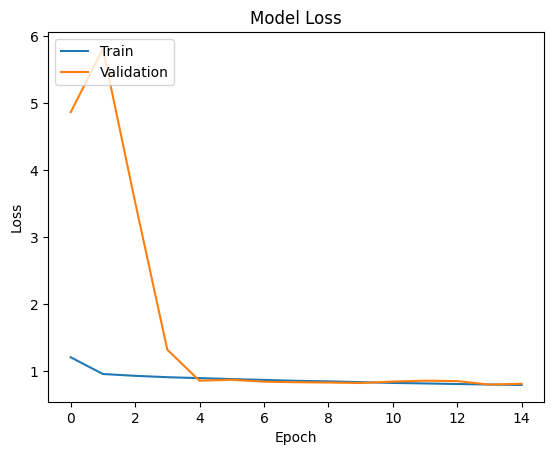

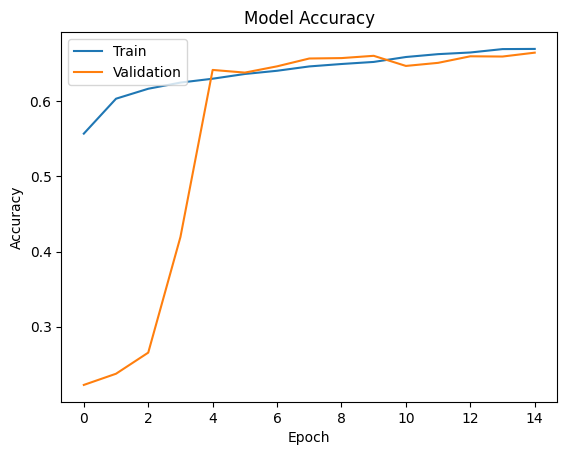

970/970 [==============================] - 6s 6ms/step


array([[  693,   608,    77,    34,     3],
       [  652,  3041,  1501,   217,     3],
       [  146,  1742, 12340,  1539,    15],
       [    6,   268,  1988,  4222,    98],
       [    0,    17,    61,  1436,   303]])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
y_val_pred = model.predict([val_fin])
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(pd.get_dummies(val_data['Sentiment']).values, axis=1)
confusion_matrix(y_val_true, y_val_pred_classes)


as we can see the this model is doing great we can try many other things like for vectorizer instead of keras we can use countvectorizer as well and also add more layers use other activation functions or optimizers as well but they will be kinda similar like this is another way:

In [7]:
df = pd.read_csv("pr-training-data.csv.csv")
final = pd.read_csv("pr-test-data.csv")
train_data, val_data = train_test_split(df, test_size=0.2, random_state=7)


vectorizer = CountVectorizer(max_features=20000, lowercase=True)
vectorizer.fit(list(df['Phrase'].values) + list(final['Phrase'].values))

train_fin = tf.keras.preprocessing.sequence.pad_sequences(vectorizer.transform(list(train_data['Phrase'].values)).toarray(), maxlen=60,  padding='post')
val_fin = tf.keras.preprocessing.sequence.pad_sequences(vectorizer.transform(list(val_data['Phrase'].values)).toarray(), maxlen=60,  padding='post')
test_fin = tf.keras.preprocessing.sequence.pad_sequences(vectorizer.transform(list(final['Phrase'].values)).toarray(), maxlen=60,  padding='post')

drive.mount('/content/drive')
file_path = './crawl-300d-2M.vec'
drive_dir_path = '/content/drive/MyDrive/Colab Notebooks/'
file_path = drive_dir_path + 'crawl-300d-2M.vec'
word_index = vectorizer.vocabulary_
embed = {}
embedding_size = 300
with open(file_path, 'r') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embed[word] = coefs
num_words = min(20000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in word_index.items():
    if i >= 20000:
        continue
    embedding_vector = embed.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
input_words = Input((60, ))
word_embeddings = Embedding(num_words, embedding_size, weights=[embedding_matrix], trainable=False)(input_words)
word_embeddings = SpatialDropout1D(0.3)(word_embeddings)
word_embeddings = Bidirectional(CuDNNLSTM(100, return_sequences=True))(word_embeddings)
word_embeddings = Dropout(0.2)(word_embeddings)
word_embeddings = Conv1D(256, 3, strides=1, padding='causal', activation='relu')(word_embeddings)
word_embeddings = BatchNormalization()(word_embeddings)
word_embeddings = Conv1D(512, 5, strides=1, padding='causal', activation='relu')(word_embeddings)
word_embeddings = BatchNormalization()(word_embeddings)
word_embeddings = GlobalMaxPool1D()(word_embeddings)
word_embeddings = Dropout(0.2)(word_embeddings)
x = Dense(100, activation="relu")(word_embeddings)
x = Dropout(0.2)(x)
predictions = Dense(5, activation="softmax")(x)
model = Model(inputs=[input_words], outputs=predictions)
model.compile(optimizer='adam' ,loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
history = model.fit([train_fin], pd.get_dummies(train_data['Sentiment']), epochs=5, verbose=1, batch_size=1024, validation_data=([val_fin], pd.get_dummies(val_data['Sentiment'])), shuffle=True)
pred_test = model.predict([test_fin], batch_size=1024, verbose = 0)
max_pred = np.round(np.argmax(pred_test, axis=1)).astype(int)
output = pd.DataFrame({'Sentiment': max_pred})
output['ID'] = range(1, len(max_pred) + 1)
output.to_csv('5.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 embedding (Embedding)       (None, 60, 300)           4572300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          321600    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 200)           0        

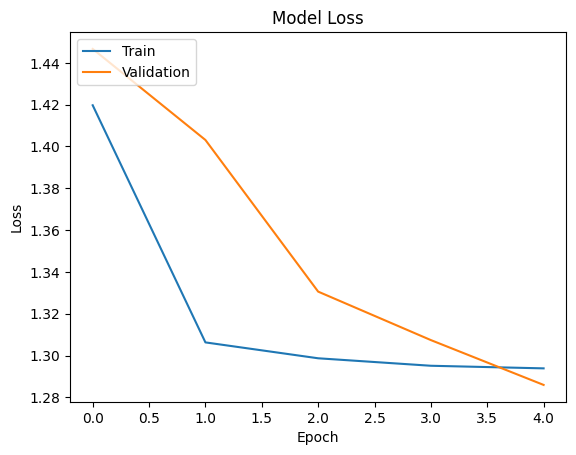

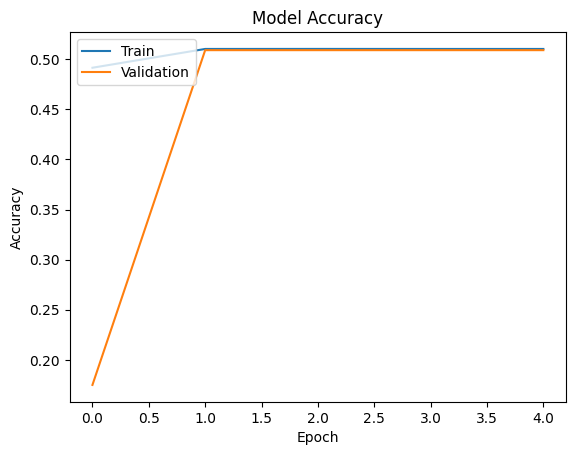

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

